In [1051]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

FIGSIZE = (20, 6)

In [1052]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209136 entries, 0 to 209135
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   index                                                  209136 non-null  int64  
 1   Data                                                   209136 non-null  object 
 2   Hora UTC                                               209136 non-null  object 
 3   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       208895 non-null  object 
 4   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  208894 non-null  object 
 5   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        208881 non-null  object 
 6   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       208881 non-null  object 
 7   RADIACAO GLOBAL (KJ/m²)                                186257 non-null  object 
 8   TEMPERATURA DO AR - BULBO SECO, HO

In [1053]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209136 entries, 2000-09-22 00:00:00 to 2024-07-31 23:00:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   global-radiation           108846 non-null  float64       
 1   total-precipitation        202315 non-null  float64       
 2   relative-humidity          202427 non-null  float64       
 3   temperature-last-hour-max  202009 non-null  float64       
 4   temperature-last-hour-min  202011 non-null  float64       
 5   wind-speed                 201407 non-null  float64       
 6   wind-speed-max-gust        200945 non-null  float64       
 7   datetime                   209136 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 14.4 MB


In [1054]:
target = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year]).mean().set_index(idx)
)

by_day = by_day.loc[by_day[target].notna()]
by_day[idx] = by_day.index
by_day[idx] = by_day[idx].apply(lambda d: d.replace(hour=0, minute=0, second=0))
by_day = by_day.set_index(idx)
by_day.head()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22,1709.000000,0.000000,69.150000,17.645000,16.665000,1.830000,4.950000
2000-09-23,1621.166667,1.166667,76.125000,18.170833,16.875000,1.558333,4.529167
2000-09-24,519.857143,0.991667,80.750000,15.516667,14.641667,2.454167,7.358333
2000-09-25,1821.769231,0.000000,61.458333,11.275000,10.229167,2.733333,7.195833
2000-09-26,1838.307692,0.000000,63.458333,12.283333,11.295833,1.750000,4.679167


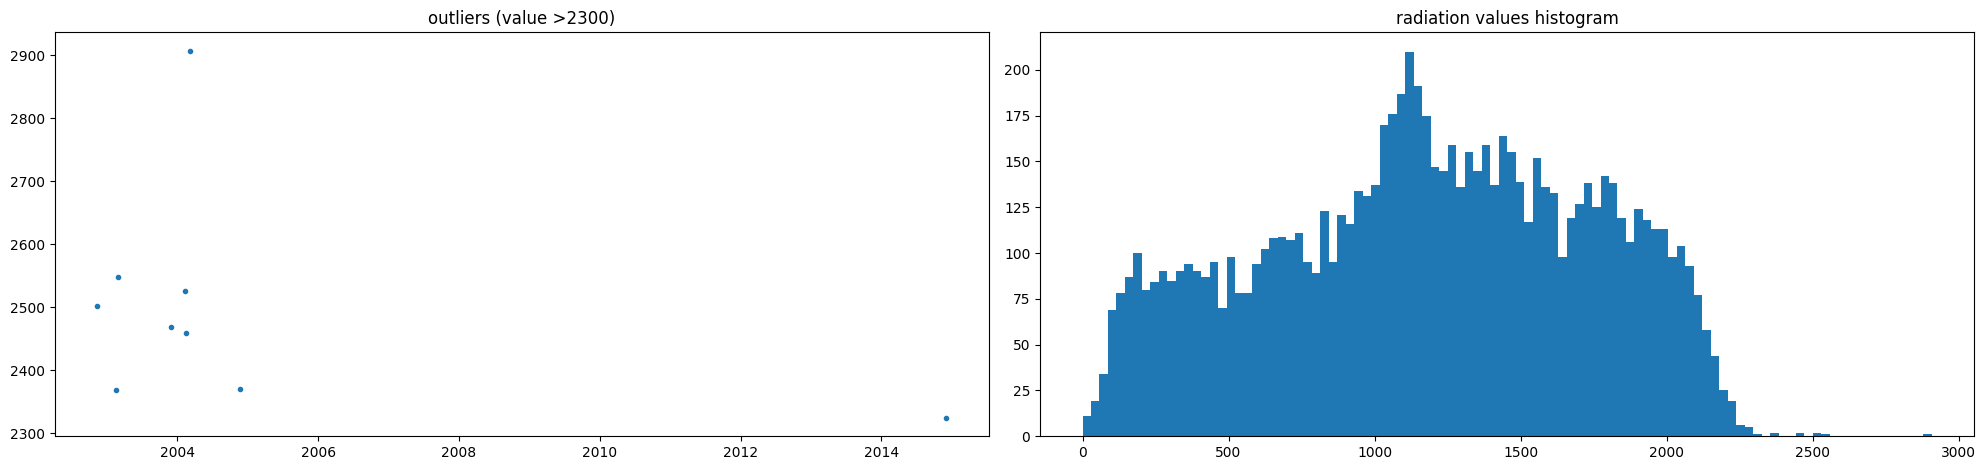

In [1055]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
cap = 2300

ax[0].set_title(f"outliers (value >{cap})")
ax[0].plot(by_day.loc[by_day[target] > cap, target], ".")

ax[1].set_title("radiation values histogram")
ax[1].hist(by_day[target], 100)

plt.tight_layout()

# by_day = by_day.loc[by_day[target] < cap]

'len(train) = 8019 | len(test) = 365'

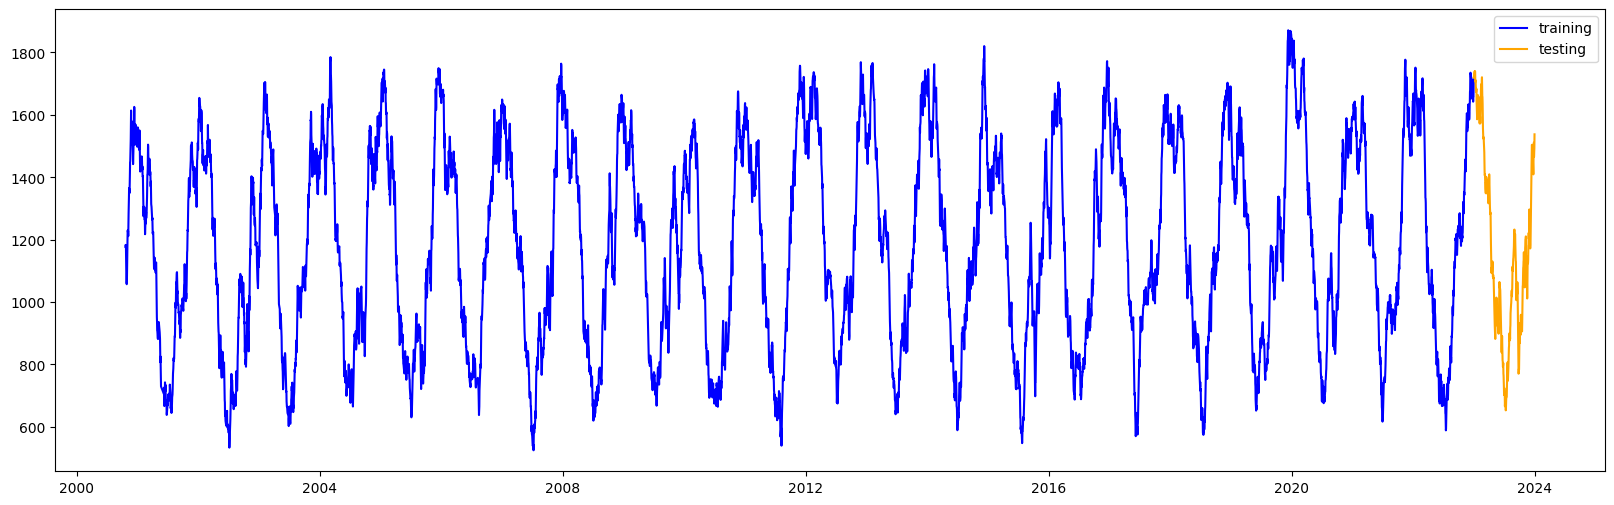

In [1056]:
date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)


def training_threshold(col):
    return col <= date_threshold


def testing_treshold(col):
    return (col >= date_threshold) & (col <= date_upper_threshold)


def split_datasets(df):
    return (
        df[training_threshold(df.index)],  # .dropna(),
        df[testing_treshold(df.index)],  # .dropna(),
    )


def make_rolling_window(df: pd.DataFrame, window_size=28):
    return df.rolling(window=window_size).mean()


train, test = split_datasets(by_day)

by_day_rolling = make_rolling_window(by_day)
train_rolling, test_rolling = split_datasets(by_day_rolling)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"len(train) = {train[target].size} | len(test) = {test[target].size}"

In [1057]:
by_day_rolling.to_csv(f"by_day_rolling_{location}.csv")

In [1058]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

from prophet import Prophet

reg = Prophet()
reg.fit(fit_data)

14:58:44 - cmdstanpy - INFO - Chain [1] start processing
14:58:47 - cmdstanpy - INFO - Chain [1] done processing


In [1059]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)

future

,ds
0,2000-10-20
1,2000-10-21
2,2000-10-22
3,2000-10-23
4,2000-10-24
...,...
10542,2029-12-26
10543,2029-12-27
10544,2029-12-28
10545,2029-12-29


/home/fellipessanha/study/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/study/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,10547,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.0,10547.0,10547.0,10547.000000
mean,2015-07-11 19:18:03.720489216,1194.318020,1040.375661,1354.380539,1160.274421,1230.498932,2.736809,2.736809,2.736809,0.000163,0.000163,0.000163,2.736645,2.736645,2.736645,0.0,0.0,0.0,1197.054829
min,2000-10-20 00:00:00,1106.847617,400.283995,764.444535,890.597382,1106.847617,-477.913492,-477.913492,-477.913492,-0.427056,-0.427056,-0.427056,-477.486436,-477.486436,-477.486436,0.0,0.0,0.0,633.372805
25%,2008-04-29 12:00:00,1160.252920,767.614277,1084.322071,1132.496817,1160.252920,-268.651572,-268.651572,-268.651572,-0.135714,-0.135714,-0.135714,-268.799973,-268.799973,-268.799973,0.0,0.0,0.0,926.136109
50%,2015-07-21 00:00:00,1210.825967,1036.686607,1355.338227,1170.771758,1210.825967,0.088805,0.088805,0.088805,-0.094514,-0.094514,-0.094514,0.515862,0.515862,0.515862,0.0,0.0,0.0,1193.504029
75%,2022-10-11 12:00:00,1232.126595,1354.925125,1649.356632,1215.998674,1238.828612,337.648146,337.648146,337.648146,0.358007,0.358007,0.358007,337.726416,337.726416,337.726416,0.0,0.0,0.0,1506.031219
max,2029-12-30 00:00:00,1258.101032,1495.523300,2045.420789,1258.101032,1630.109822,383.260280,383.260280,383.260280,0.462926,0.462926,0.462926,382.797354,382.797354,382.797354,0.0,0.0,0.0,1633.922613
std,NaN,43.278703,305.972148,311.805557,70.799377,113.402737,302.670044,302.670044,302.670044,0.284505,0.284505,0.284505,302.670070,302.670070,302.670070,0.0,0.0,0.0,304.618628


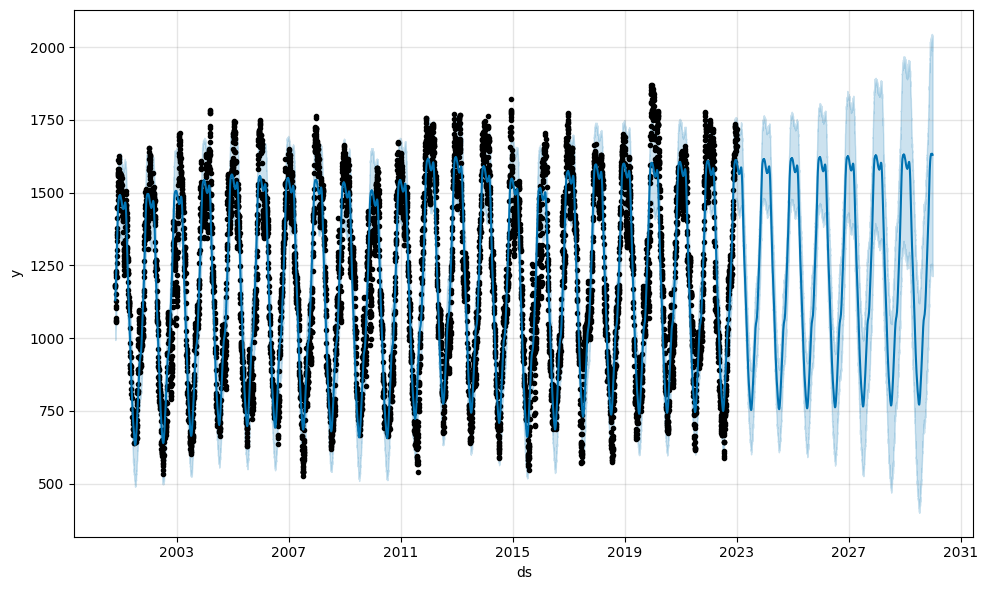

In [1060]:
forecast = reg.predict(future)
reg.plot(forecast)
forecast.describe()

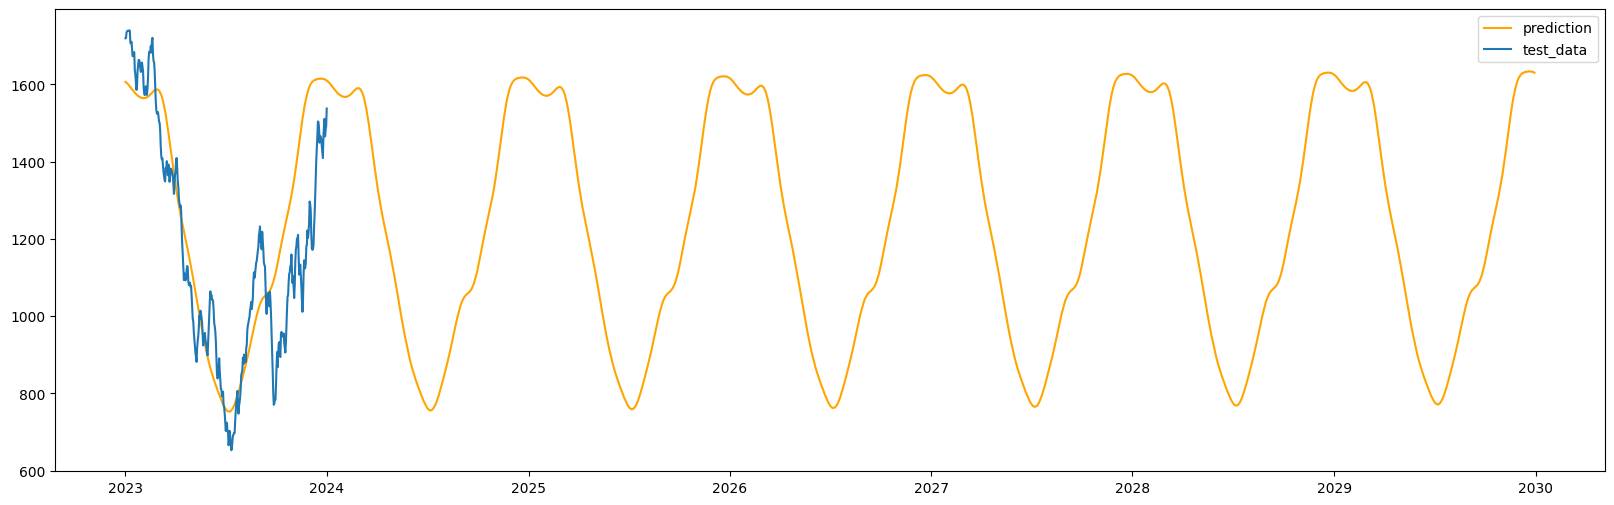

In [1061]:
prediction = forecast.loc[forecast.ds >= date_threshold, ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.1172%'

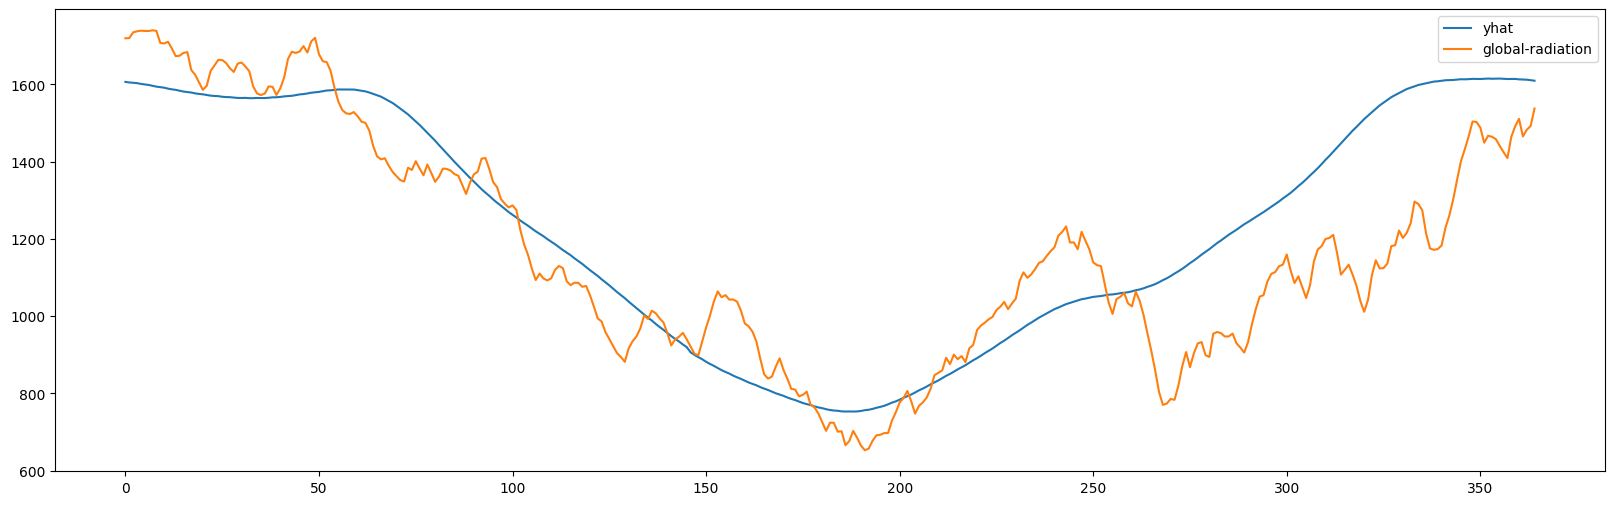

In [1062]:
from sklearn.metrics import mean_absolute_percentage_error as mape

prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat}).loc[
    testing_treshold(prediction.ds)
]
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[(comparison.yhat.notna()) & (comparison[target].notna()),]

comparison[["yhat", target]].plot(figsize=FIGSIZE)

error = mape(comparison[target], comparison.yhat)
f"predition error is {error:.4f}%"

In [1063]:
all_years = by_day.copy()
all_years["doy"] = by_day.index.day_of_year
all_years = make_rolling_window(all_years.groupby("doy").mean(), 28)

'historical error is 0.1106%'

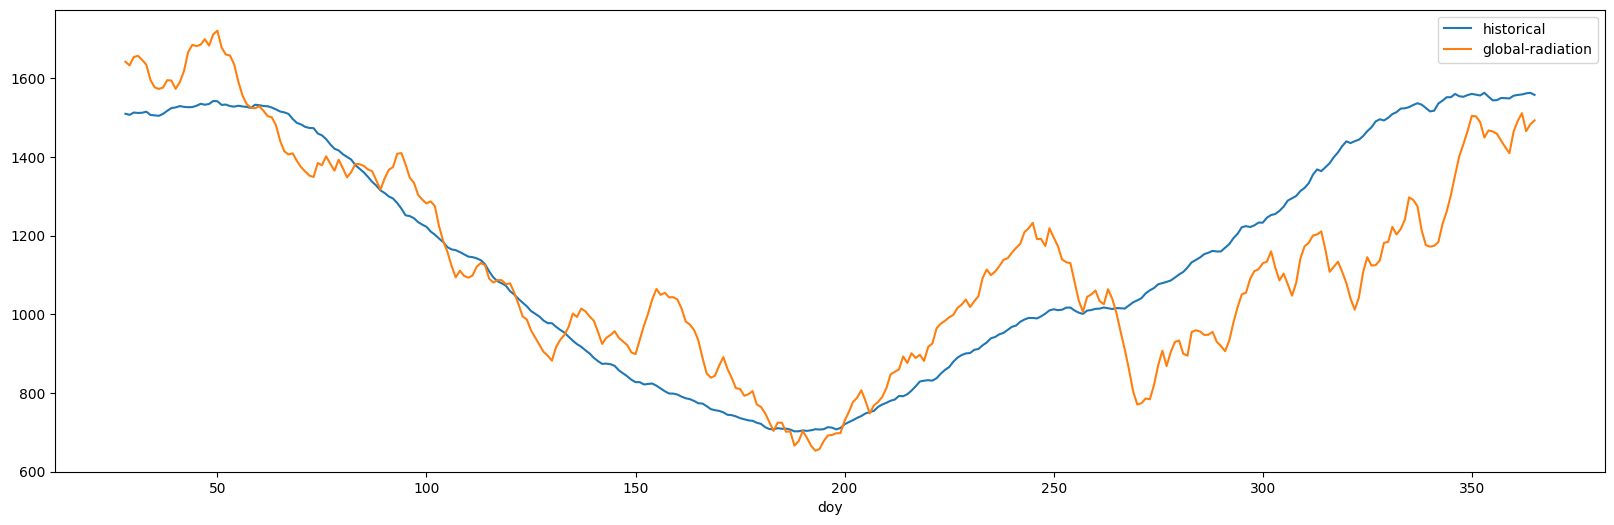

In [1064]:
last_year = test_rolling.copy()
last_year["doy"] = last_year.index.day_of_year
last_year
last_year = last_year.groupby("doy").mean()

merged = all_years.merge(last_year[[target]], on="doy").rename(
    columns={f"{target}_x": "historical", f"{target}_y": target}
)

merged = merged.loc[
    (merged.historical.notna()) & (merged[target].notna()), ["historical", target]
]
merged.plot(figsize=FIGSIZE)

error_test = mape(merged[target], merged.historical)
f"historical error is {error_test:.4f}%"

In [1065]:
xgb_df = by_day_rolling.copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df.index - pd.DateOffset(years=1)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag3"] = (xgb_df.index - pd.DateOffset(years=3)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag4"] = (xgb_df.index - pd.DateOffset(years=4)).map(
    train_rolling[target].to_dict()
)
# xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())

xgb_df["date"] = xgb_df.index

xgb_df["doy"] = xgb_df["date"].apply(lambda d: d.day_of_year)
xgb_df["woy"] = xgb_df["date"].apply(lambda d: d.date().isocalendar()[1])
xgb_df["month"] = xgb_df["date"].apply(lambda d: d.month)

xgb_df

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,lag1,lag2,lag3,lag4,date,doy,woy,month
datetime,,,,,,,,,,,,,,,
2000-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22,266,38,9
2000-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-23,267,38,9
2000-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-24,268,38,9
2000-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-25,269,39,9
2000-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-26,270,39,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-27,713.967357,0.074702,81.117560,13.881845,13.056399,1.104911,3.698810,NaN,739.068427,924.177300,778.951314,2024-07-27,209,30,7
2024-07-28,678.630019,0.081845,82.308036,14.147470,13.340476,1.082738,3.649405,NaN,709.793427,944.176326,785.543522,2024-07-28,210,30,7
2024-07-29,647.905993,0.109821,82.985119,14.268601,13.486905,1.103571,3.778423,NaN,687.178947,951.541261,821.169346,2024-07-29,211,31,7


In [1066]:
feats = ["doy", "woy", *[c for c in xgb_df.columns if "lag" in c]]
# for c in xgb_df.columns:
#     if c == target:
#         continue
#     if abs(xgb_df.corr()[target][c]) >= 0.5:
#         feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index)]
xgb_test = xgb_df.loc[testing_treshold(xgb_df.index)]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

import xgboost as xgb

reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=500,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

['doy', 'woy', 'lag1', 'lag2', 'lag3', 'lag4']
[0]	validation_0-rmse:1105.45136	validation_1-rmse:1086.60780
[100]	validation_0-rmse:102.37908	validation_1-rmse:153.28563
[200]	validation_0-rmse:93.22184	validation_1-rmse:150.04836
[300]	validation_0-rmse:87.01233	validation_1-rmse:150.47245
[400]	validation_0-rmse:82.02406	validation_1-rmse:151.09714
[500]	validation_0-rmse:78.36205	validation_1-rmse:151.30311
[600]	validation_0-rmse:75.17441	validation_1-rmse:152.51558
[658]	validation_0-rmse:73.56678	validation_1-rmse:152.49220


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

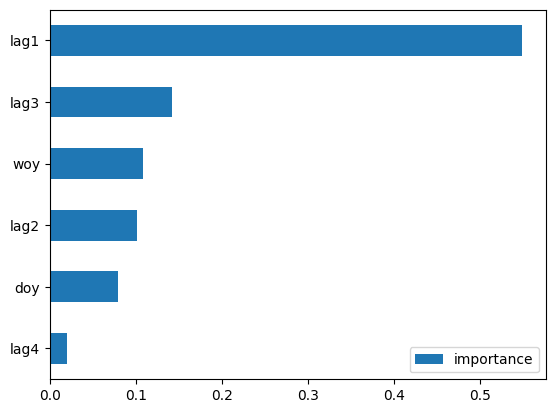

In [1067]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [1068]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(
    test_rolling.loc[testing_treshold(test_rolling.index), target],
    left_index=True,
    right_index=True,
)

xgb error = 0.1059


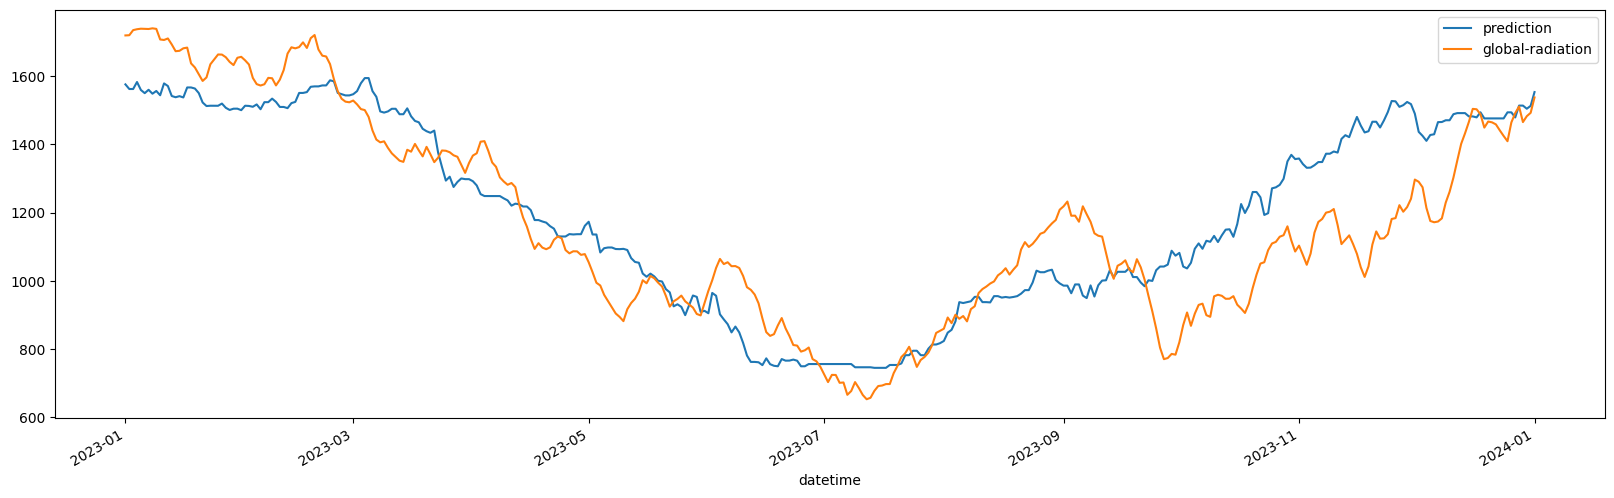

In [1069]:
prediction.plot(figsize=FIGSIZE)

xgb_error = mape(prediction[target], prediction.prediction)
print(f"xgb error = {xgb_error:.4f}")